**AST4310, Autumn 2020, Python version**

# Project 6b: Scattering
This project is based on work by Ida Hansen.

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [1]:
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy import units
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

## 1. Background

LTE radiative transfer is a powerful and widely used approximation. In LTE, matter is collisionally coupled to the local conditions. Any radiative excitation is quickly followed by a collisional de-excitation. It therefore cannot account for an essential property of radiation: scattering. The aim of this project is to get a more intuitive understanding of the properties and consequences of scattering, in particular when applied to optically thick media. 

### 1.1 Monte Carlo simulations

In the first two exercises, you will be asked to study scattering relations and visualise its effects by way of Monte Carlo simulations. These Monte Carlo simulations are nothing more than random walk calculations: you will need to generate the path of individual photons (or photon packets) in a given volume, and when a scattering event occurs, you will use a random number generator to find a new random travel direction for the photon (isotropic scattering). Here, you should always assume that scattering is elastic (no change in photon frequency).

Monte Carlo methods are widely used in radiative transfer to avoid lengthy non-LTE calculations, typically in media that are not very optically thick, such as protostellar disks, supernova remnants, and other diffuse media. See [Whitney (2011)](https://ui.adsabs.harvard.edu/abs/2011BASI...39..101W/abstract) for details and examples of Monte Carlo radiative transfer.

The random numbers of Monte Carlo are used not only to determine a new direction of travel after a scattering event, but also to determine how far a photon travels though an absorbing media, and what type of interaction it has with matter (absorption or scattering). You know that the average photon travels a physical distance of one mean free path, which in optical depth terms is equivalent to $\tau=1$. But this is a statistical average - there is also a certain probability that the photon will travel less (e.g. $\tau=0.1$) or more (e.g. $\tau=3$). This probability can be accounted for by using random number generators. The type of interaction that occurs when a photon interacts with matter will be determined probabilistically, and will depend on $\varepsilon$, the photon destruction probability:

\begin{equation}
\varepsilon_{\nu} \equiv \frac{\alpha_{\nu}^a}{\alpha_{\nu}^a + \alpha_{\nu}^s},
\end{equation}

where $\alpha_{\nu_0}^a$ and $\alpha_{\nu_0}^s$ are respectively the extinction coefficients for absorption and scattering. For example, in the case where $\varepsilon_{\nu_0}=0.5$ there is equal probability of the photon being absorbed or being scattered. If you generate a random number $\xi$ uniformly distributed between ]0, 1], its value will determine if a photon is absorbed or scattered. If $\xi \geq \varepsilon_{\nu_0}$ the photon is destroyed, while for $\xi < \varepsilon_{\nu_0}$ the photon will be scattered. When a photon is destroyed, you no longer simulate its path and can ignore it. When a photon is scattered, you proceed to advance it by one mean free path. If the photon still persists within the volume of interest, you repeat the procedure until it is either absorbed or it exists the volume, at which point you tally its position and direction. Usually the goal is to determine the density and direction of photons exiting a medium.


### 1.2 Radiative transfer within a thick scattering inhomogeneous medium

In a medium with scattering, the source function will depart from the termal Planck function. It is therefore a combination of a thermal component and a scattering component, and can be written as:

\begin{equation}
S_\nu = (1 - \varepsilon_\nu) J_\nu + \varepsilon_\nu B_\nu,
\end{equation}

where $\varepsilon_\nu$ is the photon destruction probability defined above and $J_\nu$ is the angle-averaged radiation field:

<img style="float: right;" src="Images/rte.svg" width=300px>

\begin{equation}
J_\nu (\tau_\nu) = \frac{1}{2} \int_{-1}^{1} I_\nu (\tau_\nu, \mu) d\mu.
\end{equation}

The amount of scattering thus depends on the available number of photons ($J_\nu$) and $\varepsilon_{\nu}$. With $\varepsilon_{\nu}$ close to unity, emission is mostly thermal. As $\varepsilon_{\nu}$ decreases, the amount of scattering increases and $S_\nu \to J_\nu$, the value for pure scattering.



To solve for $I_\nu$ using the radiative transfer equation, we need to know $S_\nu$, but $S_\nu$ itself depends on $I_\nu$ through the dependency of $J_\nu$. Apart from a few simple cases, it is not generally possible to solve analytically the radiative transfer equation with scattering. The way to proceed is numerically. This is most commonly done iteratively using a scheme called lambda iteration. It consists of writing the calculation of $J_\nu$ as an operator $\Lambda_\nu$ applied to the source function:

$$
S_\nu = (1 - \varepsilon_\nu) J_\nu + \varepsilon_\nu B_\nu = (1 - \varepsilon_\nu) \Lambda_\nu[S_\nu] + \varepsilon_\nu B_\nu,
$$


where $\Lambda_\nu[S_\nu]$ means *calculating $J_\nu$ for a given source function $S_\nu$.* For the first iteration, we can use the Planck function as initial guess for $S_\nu$, and afterwards we iterate such that:

\begin{cases}
S_\nu^{(0)} = B_\nu.\\
S_\nu^{(n+1)} =  (1 - \varepsilon_\nu) \,\Lambda[S_\nu^{(n)}] + \epsilon_\nu B_\nu.
\end{cases}

This iteration is repeated until a certain convergence criteria is met,

\begin{equation}
\left|\left|\frac{S_\nu^{(n+1)}-S_\nu^{(n)}}{S_\nu^{(n)}}\right| \right| < \delta.
\end{equation}

Typically, $\delta \le 10^{-3}$. For numerical stability, it is often best to split the calculation of $I_\nu$ inside $J_\nu$ into the inward-directed $I^-_\nu$ and outward-directed $I^+_\nu$:


\begin{equation}
J_\nu (\tau_\nu) = \frac{1}{2} \int_{-1}^{1} I_\nu (\tau_\nu, \mu) d\mu = \int_{0}^{1} \frac{1}{2} \left[ I^+_\nu(\tau_\nu, \mu) + I^-_\nu(\tau_\nu, \mu)\right] d\mu \equiv \Lambda_\nu[S_\nu],
\end{equation}

where $I^-_\nu$ and $I^+_\nu$ are both positive quantities and given by

\begin{eqnarray*}
I^+_\nu(\tau_\nu, \mu) &=& \frac{1}{\mu} \int_{\tau_\nu}^{\infty} S_\nu(\tau'_\nu) e^{-(\tau'_\nu - \tau_\nu)/\mu}  d\tau'_\nu,     \\
I^-_\nu(\tau_\nu, \mu) &=& \frac{1}{\mu} \int_{0}^{\tau_\nu} S_\nu(\tau'_\nu) e^{-(\tau_\nu - \tau'_\nu)/\mu}  d\tau'_\nu.
\end{eqnarray*}

The integration over $\mu$ in $J_\nu$ is usually done using a Gaussian quadrature, similar to what you did in Project 5 to compute the flux. Due to numerical inaccuracies, it is **strongly recommended** you do not attempt to solve $I^-_\nu$ and $I^+_\nu$ using direct numerical integration, but instead use the following functions:

In [2]:
from numba import jit 
from math import exp

@jit(nopython=True)
def iplus(tau, source_function, mu):
    """
    Calculates I+ for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = numpy.zeros(ndep)
    for i in range(ndep):
        i_upw = source_function[-1]
        ibot = i - len(tau)
        for j in range(-1, ibot, -1):
            expdtau = exp(-(tau[j] - tau[j - 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw
    return intensity


@jit(nopython=True)
def iminus(tau, source_function, mu):
    """
    Calculates I- for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = numpy.zeros(ndep)
    for i in range(ndep):
        i_upw = 0.
        for j in range(i):
            expdtau = exp((tau[j] - tau[j + 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw 
    return intensity

The above uses [`numba`](https://numba.pydata.org/) to speed up an otherwise pure python calculation. If you don't have numba, you can still use them (just remove the `@jit` decorator), but they will be about 300x slower. These functions still compute the same integral, but they are done incrementally on a layer-by-layer basis, a so-called piecewise integration. The other assumption in the above is that for $I^+$, the radiation at the bottom boundary is given by the local source function, and for $I^-$ the radiation at the top boundary is zero (i.e., no radiation from the observer to the star).

------------------------

### Exercise 1: Pure scattering

Consider a homogeneous slab in 3D space where there is no absorption and photons only interact with the medium through scattering.



<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
  <img style="float: right;" src="images/mfp.svg" width=200px>
    
* Use a Monte Carlo random walk calculation to show that the total path length traveled after N scatterings is $l^* \approx \sqrt{N} l$.

* For an optically thick slab of thickness D, the total number of scattering before the photon escape is $N \approx \tau^2$. Show this:
    1. Analytically
    2. Using a Monte Carlo simulation

*Hint: Plot the simulated values for different extinction values.* 
</div>

---- 
### Exercise 2: Diffusion by scattering

A rectangular box contains a medium with extinction $\alpha^a$ and $\alpha^s$ from absorption and scattering processes respectively. At the bottom of the box, photons are emitted vertically only from specific locations. The locations where photons are emitted are given by a mask saved in the file `RoCS_array.npy`, which contains an integer array. Photons should be emitted only from locations where this array is one. When plotting, be sure to use `origin='lower'` so that the orientation is correct:

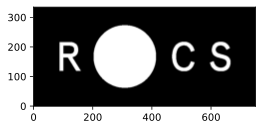

In [7]:
data = numpy.load("RoCS_array.npy")
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(data, origin='lower', cmap=plt.get_cmap('gist_gray'));

You can assume the physical size of each pixel is 1 m x 1 m. 

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

By means of a Monte Carlo simulation, study how the scattering and absorption in the medium affect the intensity measured at the top of the box (after crossing the medium). Simulate photons being emitted in pixels given by the mask above, initially all in the vertical direction. After a photon travels an optical depth of $\tau_0$, it will interact with matter and suffer one of two outcomes: be absorbed (destroyed) or be scattered. Scattered photons should be given a random new direction of travel, and then travel a new optical depth of $\tau_1$ until they have another interaction with matter. This simulation of the photon trajectory should end when the photon is absorbed or it exits the box. Photons that exit through the sides or bottom should be ignored, but record the positions and numbers of photons that cross the top boundary. Use these to build an image of the intensity at the top of the box, which should be your main output. 
    
<img style="float: right;" src="images/pattern.svg" width=300px>
    
The optical depth $\tau_i$ that a photon travels at each step $i$ should be probabilistically determined in the following way: $\tau_i = -\ln(\xi)$, where $\xi$ is a random number uniformly distributed in the interval ]0, 1]. The type of interaction (absorption or scattering) will also be probabilistically determined, based on the photon destruction probability $\varepsilon$.

There are essentially three free parameters here: $\alpha^a$, $\alpha^s$, and the height of the box. Feel free to change them as you see fit. The main objective here is to study how the different parameters affect the intensity at the top of the box. Here are some points you could focus on:
    
* For a given height of the box, what typical parameters are needed for most of the image information to reach the top? 
* When do the letters stop being visible, and when does the circle?
* How many mean free paths do the structures at the bottom need to be such that they are still visible at the top?
* How do the photon destruction probability and scattering extinction affect the diffusion of the top image?
    
    
*Hints:*
* *Chose an appropriate height of the box, and keep it constant throughout your experiments*
* *Make sure you generate enough photons so your result is not dominated by noise*
* *Given the spatial disparities in the number of photons reaching the top, it is best to plot the top image in a black/white scale, where black means no photons reached that pixel, and white means one or more photons reached it*
 
</div>

Here are two example top images for different parameters:

<img src="images/img1.svg" width=400px> <img src="images/img2.svg" width=400px>


----

### Exercise 3: Optically thick radiative transfer with scattering

In this exercise, you will go beyond LTE and calculate radiation with scattering from a solar model atmosphere. You will use the same FALC model that you used in previous projects. For simplicity, you will calculate radiation for a single wavelength. The outcome should be independent of wavelength, but since the FALC model already comes with an optical depth scale for 500 nm, it is easier to just assume a wavelength of 500 nm. 

In this exercise you will assume that $\varepsilon_\nu$ is constant throughout the atmosphere. This is not usually true: in a real atmosphere the photon destruction probability increases quickly as the density increases. You should also make use of a factor $\eta_\nu$, the ratio between the line optical depth and the continuum optical depth:

$$
\eta_\nu \equiv \frac{\tau_\nu^l}{\tau_\nu^c},
$$

so that the total optical depth can be written as:

$$
\tau_\nu^\mathrm{total} = \tau_\nu^c (1 + \eta_\nu).
$$

For $\tau_\nu^c$ use the variable `tau_500` from the FALC model.


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Write a simple lambda iteration solver that computes $J_\nu$ and $S_\nu$ for the single wavelength of 500 nm as a function of $\tau_\nu^c$, $B_\nu$, $\eta_\nu$, and $\varepsilon_\nu$. You can obtain $B_\nu$ by using the temperatures in a model atmosphere.
    
* Using your solver, compute $J_\nu$ and $S_\nu$ for the FALC model atmosphere. Run for $\varepsilon_\nu = [0.5, 10^{-2}, 10^{-3}]$, and $\eta_\nu= [10^2, 10^4, 10^6]$ and for each of the nine combinations plot $J_\nu$, $S_\nu$, and $B_\nu$ vs $\tau_\nu^c$. 
    
* Explain what is happening in physical terms. How does $\eta_\nu$ affect the result? And $\varepsilon_\nu$? When is LTE no longer valid? At what point is radiation thermalised ($J_\nu \approx B_\nu$)?
    
* Scattering makes radiation decouple from the local conditions deeper in the atmosphere that it would otherwise. So the photons that reach the surface are effectively formed in deeper layers. But scattering can greatly reduce the number of photons that reach the surface (e.g. see decrease in $J_\nu$). The more scattering, the fewer photons reaching the surface. Why is that? 
    
* Assuming $\varepsilon_\nu$ is constant with height helps understand scattering, but is a poor approximation. Compute and plot the height-dependent $\varepsilon_\nu$ for the FALC model at 500 nm, using the extinction sources you computed in Project 4 (H$^{-}$ extinction and Thomson scattering). At which height does scattering start to be important?
 
    
*Hints:*
* *The simple lambda iteration method struggles for $\varepsilon_\nu \ll 1$. Do not run for $\varepsilon_\nu < 10^{-3}$.*
* *You can check if your solution is physical by noting that in the interior of the star, TE holds, so $J_\nu = S_\nu = B_\nu$. If this stops being the case, you have some numerical errors.*
* *If you use the original FALC depth grid with 80 depth points, lambda iteration will start failing around $\varepsilon_\nu < 10^{-1}$. This can be mitigated by using a higher resolution optical depth grid, for example by interpolating the FALC values to a finer grid. The lower the $\varepsilon_\nu$, the more depth points you will need to avoid numerical errors.*
 
</div>